# **Visualization of different results**

In [1]:
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MEAS_ROOT = "../02_data/"
SEEDS = [42, 1812, 9698, 424, 820, 75, 98, 65535, 16383, 513]
PENS = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#PENS = [2, 4, 6, 8]
EPSILON = 10

In [3]:
EUR_HUF = 411.43 #2024-11-24

In [4]:
def read_data(seed, meas_path, col_name, col_value):
    with open(f"{meas_path}/veh_results.json") as f:
        veh_res = json.load(f)
    veh_data = pd.DataFrame.from_dict(veh_res, orient="index")
    veh_data.index = veh_data.index.astype(int)
    
    trip_df = pd.read_xml(f"{meas_path}/vehicle_trips.xml", xpath = "tripinfo")
    trip_df["id"] = trip_df["id"].astype(int)
    
    vd = pd.merge(left=trip_df, right=veh_data, left_on="id", right_index=True)
    
    vd[col_name] = [col_value]*len(vd)
    
    return vd

In [5]:
#read penetration data:

penetration_df = pd.DataFrame()

for seed in SEEDS:
    penetration_df = pd.concat([penetration_df,
                            read_data(seed, f"{MEAS_ROOT}/ideal{seed}/", "penetration", "100%")
                           ], ignore_index=True)
    
for seed in SEEDS:
    penetration_df = pd.concat([penetration_df,
                            read_data(seed, f"{MEAS_ROOT}/baseline{seed}/", "penetration", "0%")
                           ], ignore_index=True)
    
for seed in SEEDS:
    info_df = read_data(seed, f"{MEAS_ROOT}/information{seed}/", "penetration", "info.")
    info_df["controlled"] = False
    info_df["paid_price"] = info_df["parking_price"]
    penetration_df = pd.concat([penetration_df, info_df], ignore_index=True)
    
for pen in PENS:
    for seed in SEEDS:
        penetration_df = pd.concat([penetration_df,
                                read_data(seed, f"{MEAS_ROOT}/pen{pen}:{seed}/", "penetration", f"{pen*10}%")
                               ], ignore_index=True)

In [6]:
penetration_df["prolonged_distance"] = penetration_df["routeLength"] - penetration_df["original_distance"]

penetration_df["paid_price"] = penetration_df["paid_price"]/EUR_HUF
penetration_df["auction_price"] = penetration_df["auction_price"]/EUR_HUF

In [7]:
values = []
value_types = []
pens = []
controlled = []

for _,r in penetration_df.iterrows():
    values.append(r["rerouteNo"])
    value_types.append("n_reroutes")
    controlled.append(r["controlled"])
    pens.append(r["penetration"])
    
    values.append(r["routeLength"]/1000)
    value_types.append("distance")
    controlled.append(r["controlled"])
    pens.append(r["penetration"])
    
    values.append(r["prolonged_distance"]/1000)
    value_types.append("prolonged_distance")
    controlled.append(r["controlled"])
    pens.append(r["penetration"])
    
    values.append(r["parking_distance"]/1000)
    value_types.append("parking_distance")
    controlled.append(r["controlled"])
    pens.append(r["penetration"])
    
    values.append(r["paid_price"])
    value_types.append("paid_price")
    controlled.append(r["controlled"])
    pens.append(r["penetration"])
    
    values.append(r["auction_price"])
    value_types.append("auction_price")
    controlled.append(r["controlled"])
    pens.append(r["penetration"])
    
    values.append(r["occupied_reserved"])
    value_types.append("occupied_reserved")
    controlled.append(r["controlled"])
    pens.append(r["penetration"])
    
long_df = pd.DataFrame()
long_df["values"] = values
long_df["value_types"] = value_types
long_df["controlled"] = controlled
long_df["penetration"] = pens

### **Reroutes**

In [8]:
labels = ["0%", "info."] + [f"{i}%" for i in range(10, 110, 10)]

In [9]:
def plot_values(ax, df, value_type, value_name, legend=False):
    #collect data:
    percents = {
        5: [],
        25: [],
        50: [],
        75: [],
        95: []
    }

    for pen in labels:
        df_filt = df[df["value_types"] == value_type]
        df_filt = df_filt[df_filt["penetration"] == pen]
        for p in percents:
            q = p/100
            percents[p].append(df_filt["values"].quantile(q))
    
    #plot data:
    ax.fill_between(labels, percents[5], percents[95], color="tab:blue", alpha=.2, label="5-95%")
    ax.fill_between(labels, percents[25], percents[75], color="tab:blue", alpha=.4, label="25-75%")
    ax.plot(labels, percents[50], color="k", linewidth=3, label="50%")
    if legend:
        ax.legend(title="quantiles")
    ax.set_xlabel("penetration")
    ax.set_ylabel(value_name)

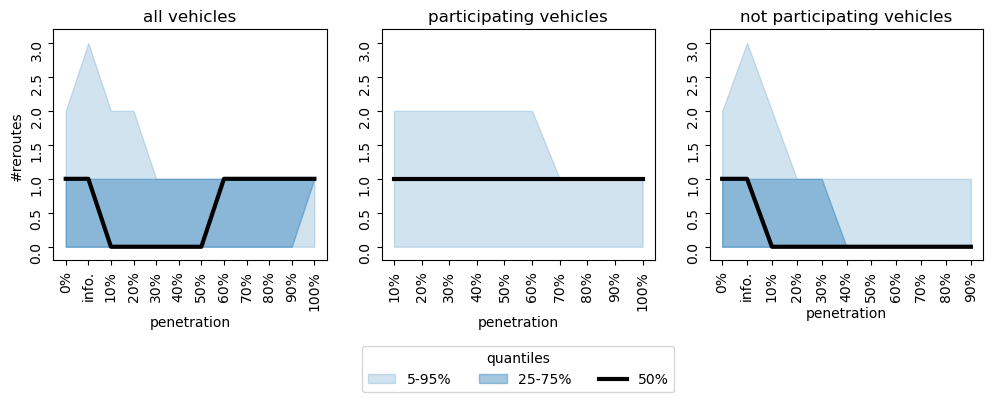

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

Y_MIN, Y_MAX = -0.2, 3.2

plot_values(ax[0], long_df, "n_reroutes", "#reroutes")
ax[0].set_title("all vehicles")
ax[0].tick_params(labelrotation=90)

plot_values(ax[1], long_df[long_df["controlled"]], "n_reroutes", "#reroutes")
ax[1].set_ylabel("")
ax[1].set_title("participating vehicles")
ax[1].tick_params(labelrotation=90)
ax[1].legend(title="quantiles", loc="lower center", ncols=3, bbox_to_anchor=(0.5, -0.6))

plot_values(ax[2], long_df[~long_df["controlled"]], "n_reroutes", "#reroutes")
ax[2].set_ylabel("")
ax[2].set_title("not participating vehicles")
ax[2].tick_params(labelrotation=90)

for axis in range(3):
    ax[axis].set_ylim(Y_MIN, Y_MAX)

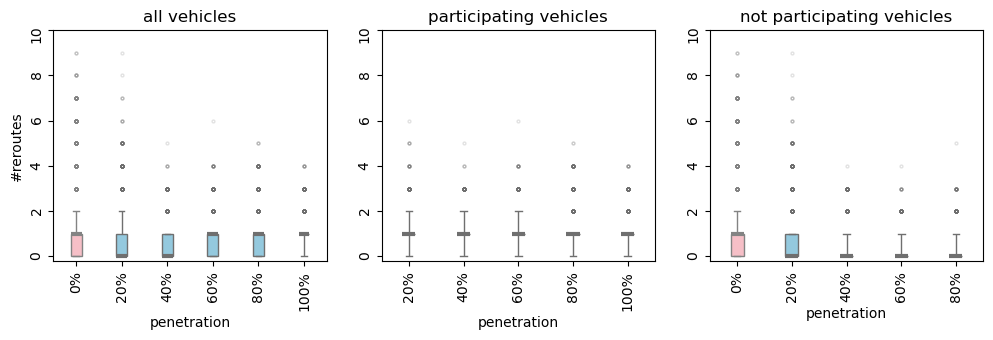

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
Y_MIN, Y_MAX = -0.2, 10

uncoord_df = long_df[long_df["penetration"] == "0%"]
sns.boxplot(uncoord_df[uncoord_df["value_types"] == "n_reroutes"], x="penetration", y="values",
           width=.3, gap=.2, whis=[5, 95], color="lightpink",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[0])
coord_df = long_df[long_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "n_reroutes"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 100, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[0])
ax[0].set_ylabel("#reroutes")
ax[0].set_title("all vehicles")
ax[0].tick_params(labelrotation=90)

coord_df = long_df[long_df["controlled"]]
coord_df = coord_df[coord_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "n_reroutes"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 100, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_title("participating vehicles")
ax[1].tick_params(labelrotation=90)

coord_df = long_df[~long_df["controlled"]]
uncoord_df = long_df[long_df["penetration"] == "0%"]
sns.boxplot(uncoord_df[uncoord_df["value_types"] == "n_reroutes"], x="penetration", y="values",
           width=.3, gap=.2, whis=[5, 95], color="lightpink",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[2])
coord_df = coord_df[coord_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "n_reroutes"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 80, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_title("not participating vehicles")
ax[2].tick_params(labelrotation=90)

for axis in range(3):
    ax[axis].set_ylim(Y_MIN, Y_MAX)

### **Distance**

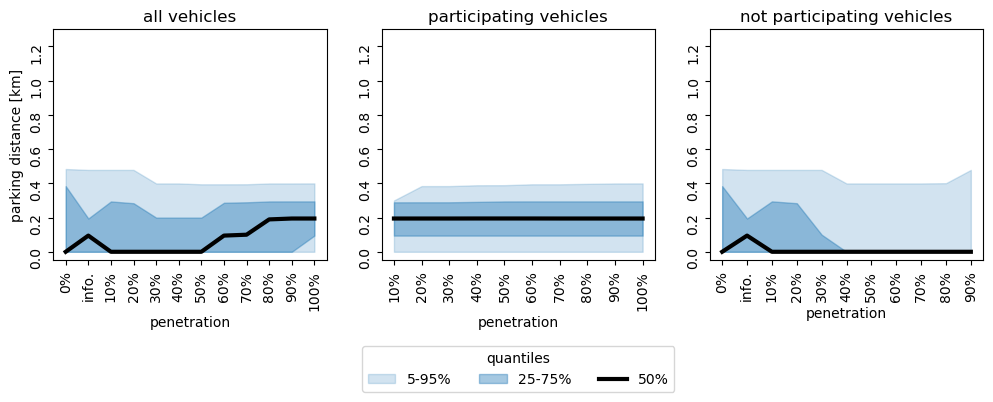

In [12]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

Y_MIN, Y_MAX = -0.05, 1.300
Y_TICKS = [0, 250, 500, 750, 1000, 1250]

plot_values(ax[0], long_df, "parking_distance", "parking distance [km]")
ax[0].set_title("all vehicles")
ax[0].tick_params(labelrotation=90)

plot_values(ax[1], long_df[long_df["controlled"]], "parking_distance", "parking distance [km]")
ax[1].set_ylabel("")
ax[1].set_title("participating vehicles")
ax[1].tick_params(labelrotation=90)
ax[1].legend(title="quantiles", loc="lower center", ncols=3, bbox_to_anchor=(0.5, -0.6))

plot_values(ax[2], long_df[~long_df["controlled"]], "parking_distance", "parking distance [km]")
ax[2].set_ylabel("")
ax[2].set_title("not participating vehicles")
ax[2].tick_params(labelrotation=90)

for axis in range(3):
    ax[axis].set_ylim(Y_MIN, Y_MAX)

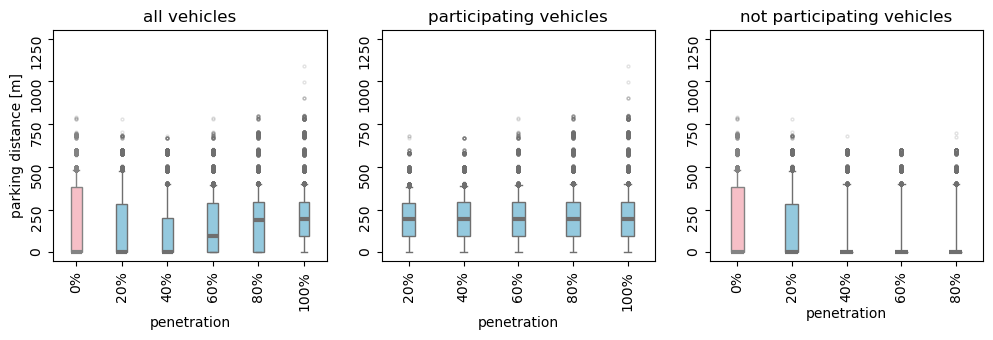

In [13]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
Y_MIN, Y_MAX = -50, 1300
Y_TICKS = [0, 250, 500, 750, 1000, 1250]

uncoord_df = long_df[long_df["penetration"] == "0%"]
sns.boxplot(uncoord_df[uncoord_df["value_types"] == "parking_distance"], x="penetration", y="values",
           width=.3, gap=.2, whis=[5, 95], color="lightpink",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[0])
coord_df = long_df[long_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "parking_distance"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 100, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[0])
ax[0].set_ylabel("parking distance [m]")
ax[0].set_title("all vehicles")
ax[0].tick_params(labelrotation=90)

coord_df = long_df[long_df["controlled"]]
coord_df = coord_df[coord_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "parking_distance"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 100, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_title("participating vehicles")
ax[1].tick_params(labelrotation=90)

coord_df = long_df[~long_df["controlled"]]
uncoord_df = long_df[long_df["penetration"] == "0%"]
sns.boxplot(uncoord_df[uncoord_df["value_types"] == "parking_distance"], x="penetration", y="values",
           width=.3, gap=.2, whis=[5, 95], color="lightpink",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[2])
coord_df = coord_df[coord_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "parking_distance"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 80, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_title("not participating vehicles")
ax[2].tick_params(labelrotation=90)

for axis in range(3):
    ax[axis].set_ylim(Y_MIN, Y_MAX)
    ax[axis].set_yticks(Y_TICKS)

Text(0, 0.5, 'successful reservation ratio')

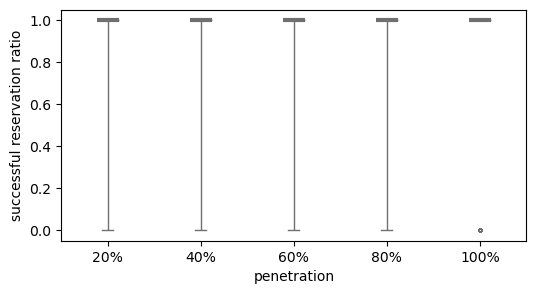

In [14]:
fig, ax = plt.subplots(figsize=(6,3))
coord_df = long_df[long_df["controlled"]]
sns.boxplot(coord_df[coord_df["value_types"] == "occupied_reserved"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 100, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3})
ax.set_ylabel("successful reservation ratio")

### **Prices**

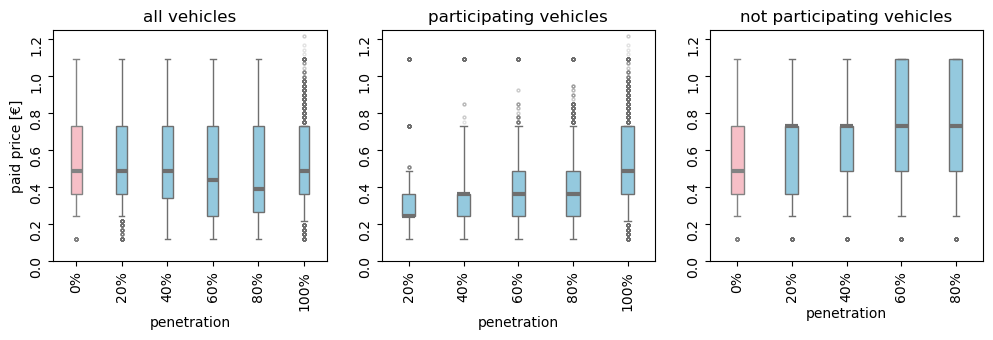

In [15]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
Y_MIN, Y_MAX = 0, 1.25

uncoord_df = long_df[long_df["penetration"] == "0%"]
sns.boxplot(uncoord_df[uncoord_df["value_types"] == "paid_price"], x="penetration", y="values",
           width=.3, gap=.2, whis=[5, 95], color="lightpink",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[0])
coord_df = long_df[long_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "paid_price"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 100, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[0])
ax[0].set_ylabel("paid price [€]")
ax[0].set_title("all vehicles")
ax[0].tick_params(labelrotation=90)

coord_df = long_df[long_df["controlled"]]
coord_df = coord_df[coord_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "paid_price"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 100, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_title("participating vehicles")
ax[1].tick_params(labelrotation=90)

coord_df = long_df[~long_df["controlled"]]
uncoord_df = long_df[long_df["penetration"] == "0%"]
sns.boxplot(uncoord_df[uncoord_df["value_types"] == "paid_price"], x="penetration", y="values",
           width=.3, gap=.2, whis=[5, 95], color="lightpink",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[2])
coord_df = coord_df[coord_df["penetration"] != "0%"]
sns.boxplot(coord_df[coord_df["value_types"] == "paid_price"], x="penetration", y="values", order=[f"{x+20}%" for x in range(0, 80, 20)],
           width=0.3, gap=0.2, whis=[5, 95], color="skyblue",
           fliersize=2.0, flierprops={"alpha": 0.2},
           medianprops={"linewidth":3}, ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_title("not participating vehicles")
ax[2].tick_params(labelrotation=90)

for axis in range(3):
    ax[axis].set_ylim(Y_MIN, Y_MAX)

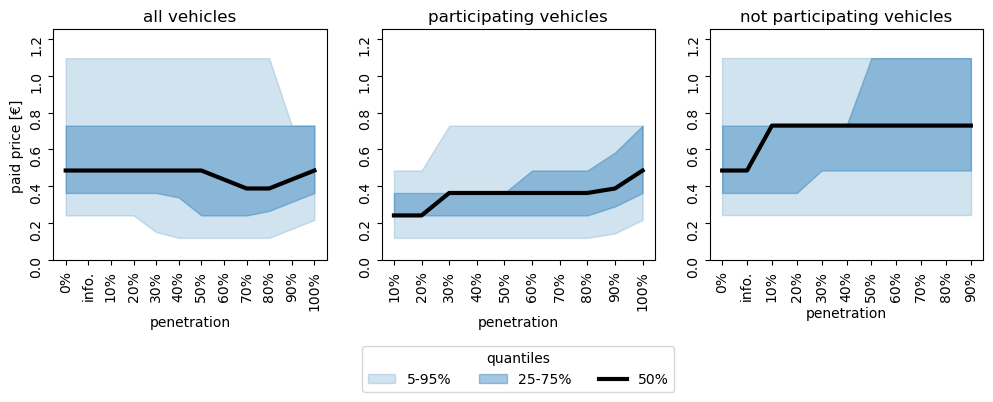

In [16]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

Y_MIN, Y_MAX = 0, 1.25

plot_values(ax[0], long_df, "paid_price", "paid price [€]")
ax[0].set_title("all vehicles")
ax[0].tick_params(labelrotation=90)

plot_values(ax[1], long_df[long_df["controlled"]], "paid_price", "paid price []")
ax[1].set_ylabel("")
ax[1].set_title("participating vehicles")
ax[1].tick_params(labelrotation=90)
ax[1].legend(title="quantiles", loc="lower center", ncols=3, bbox_to_anchor=(0.5, -0.6))

plot_values(ax[2], long_df[~long_df["controlled"]], "paid_price", "paid price []")
ax[2].set_ylabel("")
ax[2].set_title("not participating vehicles")
ax[2].tick_params(labelrotation=90)

for axis in range(3):
    ax[axis].set_ylim(Y_MIN, Y_MAX)

In [17]:
info_df = long_df[long_df["penetration"] == "info."]
info_df[info_df["value_types"] == "paid_price"]["values"].unique()

array([1.093746202270131, 0.729164134846754, 0.24305471161558467,
       0.364582067423377, 0.48610942323116935, 0.12152735580779234, nan],
      dtype=object)

In [18]:
long_df

,values,value_types,controlled,penetration
0,1,n_reroutes,True,100%
1,976.26,distance,True,100%
2,97.34,prolonged_distance,True,100%
3,97.34,parking_distance,True,100%
4,0.121527,paid_price,True,100%
...,...,...,...,...
9676795,99.79,prolonged_distance,True,90%
9676796,299.79,parking_distance,True,90%
9676797,0.364582,paid_price,True,90%
9676798,0.364582,auction_price,True,90%


In [19]:
total_parking_prices = []
participating_parking_prices = []
not_participating_parking_prices = []

for pen in labels:
    df_filt = long_df[long_df["penetration"] == pen]
    pp = df_filt[df_filt["value_types"] == "paid_price"]
    total_parking_prices.append(pp["values"].sum())
    participating_parking_prices.append(pp[pp["controlled"] == True]["values"].sum())
    not_participating_parking_prices.append(pp[pp["controlled"] == False]["values"].sum())

In [20]:
total_parking_prices = np.array(total_parking_prices)/10
participating_parking_prices = np.array(participating_parking_prices)/10
not_participating_parking_prices = np.array(not_participating_parking_prices)/10

participating_parking_prices[participating_parking_prices == 0] = None
not_participating_parking_prices[not_participating_parking_prices == 0] = None

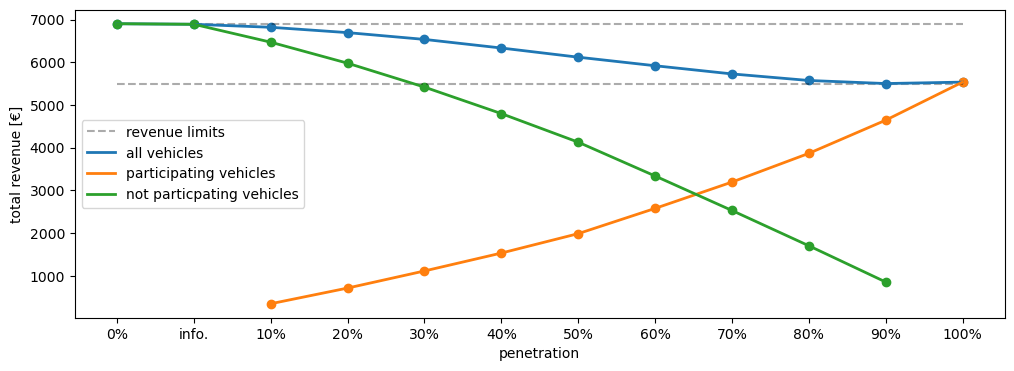

In [21]:
plt.figure(figsize=(12,4))

plt.hlines(y=max(total_parking_prices), xmin=0, xmax=len(labels)-1, linestyle="--", color="k", alpha=.33)
plt.hlines(y=min(total_parking_prices), xmin=0, xmax=len(labels)-1, linestyle="--", color="k", alpha=.33,
           label="revenue limits")

plt.plot(labels, total_parking_prices, label="all vehicles", linewidth=2)
plt.scatter(labels, total_parking_prices)
plt.plot(labels, participating_parking_prices, label="participating vehicles", linewidth=2)
plt.scatter(labels, participating_parking_prices)
plt.plot(labels, not_participating_parking_prices, label="not particpating vehicles", linewidth=2)
plt.scatter(labels, not_participating_parking_prices)

plt.xlabel("penetration")
plt.ylabel("total revenue [€]")
plt.legend()

In [28]:
total_parking_prices

array([6901.27117615, 6888.19483266, 6817.98118757, 6692.97328829,
       6534.12731206, 6332.76863622, 6118.2922976 , 5918.1683397 ,
       5726.6339353 , 5573.07926014, 5501.24687067, 5534.70335173])

## **Traffic flow**

In [22]:
mean_hmspeeds = {}
for seed in SEEDS:
    flow_df = pd.read_xml(f"{MEAS_ROOT}/ideal{seed}/detector_data.out.xml", xpath="interval")
    mean_hmspeeds["100%"] = flow_df.groupby("begin")["flow"].mean()
    
for seed in SEEDS:
    flow_df = pd.read_xml(f"{MEAS_ROOT}/baseline{seed}/detector_data.out.xml", xpath="interval")
    mean_hmspeeds["unc"] = flow_df.groupby("begin")["flow"].mean()
    
for seed in SEEDS:
    flow_df = pd.read_xml(f"{MEAS_ROOT}/information{seed}/detector_data.out.xml", xpath="interval")
    mean_hmspeeds["info."] = flow_df.groupby("begin")["flow"].mean()
    
for pen in PENS:
    for seed in SEEDS:
        flow_df = pd.read_xml(f"{MEAS_ROOT}/pen{pen}:{seed}/detector_data.out.xml", xpath="interval")
        mean_hmspeeds[f"{10*pen}%"] = flow_df.groupby("begin")["flow"].mean()

(90.0, 165.0)

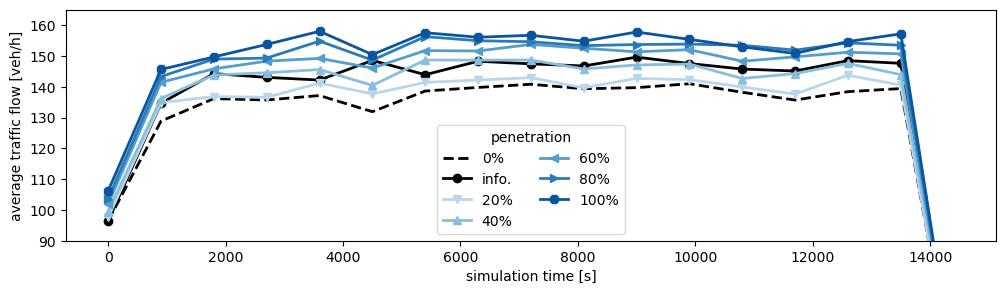

In [23]:
plt.figure(figsize=(12,3))

MARKERS = ["v", "^", "<", ">", "8"]

plot_flow = {}
for pen in mean_hmspeeds:
    plot_flow[pen] = {
        "flow": [],
        "time": []
    }
    for t in mean_hmspeeds[pen].index:
        if t<=14400:
            plot_flow[pen]["flow"].append(mean_hmspeeds[pen][t])
            plot_flow[pen]["time"].append(t)
            
            
plt.plot(plot_flow["unc"]["time"], plot_flow["unc"]["flow"], "--", color="k", label="0%",
         linewidth=2)
plt.plot(plot_flow["info."]["time"], plot_flow["info."]["flow"], "-o", color="k", label="info.",
         linewidth=2)

colors = plt.cm.Blues(np.linspace(0, 1, 8))
for i,pen in enumerate(range(0, 100, 20)):
    plt.plot(plot_flow[f"{pen+20}%"]["time"],
             plot_flow[f"{pen+20}%"]["flow"],
             label=f"{pen+20}%", color=colors[i+2], marker = MARKERS[i],
             linewidth=2)
    
plt.legend(title="penetration", ncols=2)
plt.xlabel("simulation time [s]")
plt.ylabel("average traffic flow [veh/h]")
plt.ylim(90,165)

## **Parking lot usage**

## **Parking occupancy trends**

In [10]:
def get_distance_line_model(edge_id):
    row_distance_1 = max(ord('C') - ord(edge_id[0]),
                         ord(edge_id[0]) - ord('D'))
    row_distance_2 = max(ord('C') - ord(edge_id[2]),
                         ord(edge_id[2]) - ord('D'))
    row_distance = max(row_distance_1, row_distance_2)
    
    column_distance_1 = max((2 - int(edge_id[1])),
                            (int(edge_id[1]) - 3))
    column_distance_2 = max((2 - int(edge_id[3])),
                            (int(edge_id[3]) - 3))
    column_distance = max(column_distance_1, column_distance_2)
    
    return np.round(np.sqrt((row_distance*100)**2 + (column_distance*100)**2), decimals=0)

In [11]:
def compute_line_occups(occup_df):
    mean_occups = occup_df.groupby("parking_id")["occupancy"].mean()
    distances = []
    occupancies = []

    for i in mean_occups.index:
        dist = get_distance_line_model(i[2:])
        distances.append(dist)
        occupancies.append(mean_occups[i])

    occup_df = pd.DataFrame()
    occup_df["distance"] = distances
    occup_df["occupancy"] = occupancies
    return occup_df

### **Penetrations**

In [12]:
line_occups = pd.DataFrame()
for seed in SEEDS:
    occup_df = pd.read_csv(f"{MEAS_ROOT}/ideal{seed}/occupancy.csv")
    occup_df = compute_line_occups(occup_df)
    occup_df["penetration"] = ["100%"]*len(occup_df)
    line_occups = pd.concat([line_occups, occup_df])
    
for seed in SEEDS:
    occup_df = pd.read_csv(f"{MEAS_ROOT}/baseline{seed}/occupancy.csv")
    occup_df = compute_line_occups(occup_df)
    occup_df["penetration"] = ["0%"]*len(occup_df)
    line_occups = pd.concat([line_occups, occup_df])
    
for seed in SEEDS:
    occup_df = pd.read_csv(f"{MEAS_ROOT}/information{seed}/occupancy.csv")
    occup_df = compute_line_occups(occup_df)
    occup_df["penetration"] = ["info."]*len(occup_df)
    line_occups = pd.concat([line_occups, occup_df])
    
for pen in PENS:
    for seed in SEEDS:
        occup_df = pd.read_csv(f"{MEAS_ROOT}/pen{pen}:{seed}/occupancy.csv")
        occup_df = compute_line_occups(occup_df)
        occup_df["penetration"] = [f"{10*pen}%"]*len(occup_df)
        line_occups = pd.concat([line_occups, occup_df])

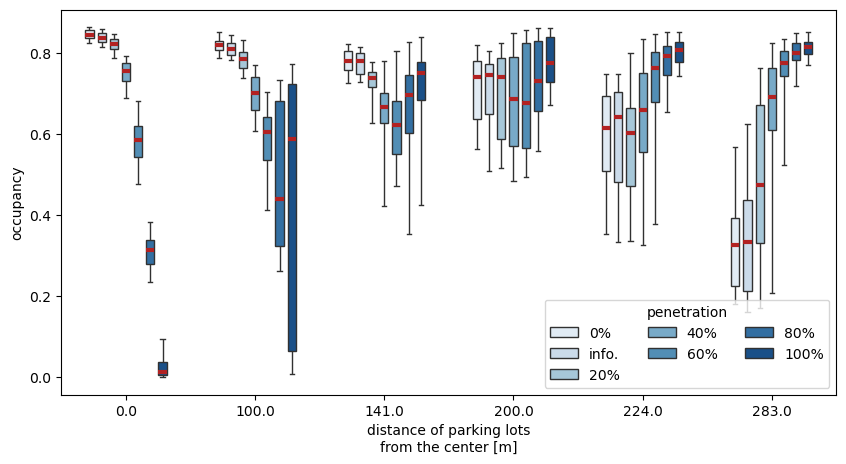

In [13]:
plt.figure(figsize=(10, 5))
sns.boxplot(line_occups, x="distance", y="occupancy", hue="penetration",
            #hue_order=["unc", "10%", "20%", "30%", "40%", "50%", "60%",
            #           "70%", "80%", "90%", "100%"],
            hue_order=["0%", "info.", "20%", "40%", "60%",
                       "80%", "100%"],
            width=.66, gap=0.33, whis=[5, 95],
            fliersize=2.0, flierprops={"alpha": 0.2},
            medianprops={"linewidth":3, "color":"firebrick"},
            palette="Blues", showfliers=False)
plt.xlabel("distance of parking lots\nfrom the center [m]")
plt.legend(loc="lower right", ncols=3, title="penetration")